## qDRIFT

In this notebook we demonstrate how the TOPP-HATT optimisation procedure can be used to reduce the untranspiled and transpiled circuit depth of qDRIFT Hamiltonian simulation circuits.

In [1]:
import rustworkx as rx
import matplotlib.pyplot as plt
import numpy as np
import json
from pathlib import Path
from qiskit import QuantumCircuit
import qiskit.qasm2
import ferrmion as fr
from ferrmion.optimize import bonsai_algorithm
from qiskit.transpiler import CouplingMap
from qiskit import transpile

In [2]:
ROOT_SEED = 12345  # this seed controls all randomness in the notebook

In [3]:
# qDRIFT simlulation functions
# these functions are from the TN4QA package
# https://github.com/UCL-CCS/TN4QA

# current dependency conflicts prevent direct import
# this will be resolved in a future release of TN4QA


def exp_pauli_string_to_circ(pauli_string: str, rot_angle: float) -> QuantumCircuit:
    qc = QuantumCircuit(len(pauli_string))

    if pauli_string == "I" * len(pauli_string):
        return qc

    for p_idx in range(len(pauli_string)):
        p = pauli_string[p_idx]
        if p == "X":
            qc.h(p_idx)
        elif p == "Y":
            qc.sdg(p_idx)
            qc.h(p_idx)

    non_id_qubits = [
        p_idx for p_idx in range(len(pauli_string)) if pauli_string[p_idx] != "I"
    ]
    for non_id_idx in range(len(non_id_qubits) - 1):
        q1, q2 = non_id_qubits[non_id_idx], non_id_qubits[non_id_idx + 1]
        qc.cx(q1, q2)
    qc.rz(2 * rot_angle, non_id_qubits[-1])
    for non_id_idx in range(len(non_id_qubits) - 1):
        q1, q2 = non_id_qubits[non_id_idx], non_id_qubits[non_id_idx + 1]
        qc.cx(q1, q2)

    for p_idx in range(len(pauli_string)):
        p = pauli_string[p_idx]
        if p == "X":
            qc.h(p_idx)
        elif p == "Y":
            qc.h(p_idx)
            qc.s(p_idx)
    return qc


def QDriftSimulation(
    ham: dict[str, float],
    duration: float,
    error: float | None = None,
    seed: int | None = None,
) -> QuantumCircuit:
    norm = np.sum([np.abs(x) for x in ham.values()])

    if error is None:
        error = 1e-3

    num_terms = int(np.ceil(2 * (norm**2) * (duration**2) / error))

    pauli_strings = list(ham.keys())
    num_qubits = len(pauli_strings[0])
    qc = QuantumCircuit(num_qubits)

    term_idxs = list(range(len(list(ham.keys()))))
    probs = [np.abs(weight) / norm for weight in ham.values()]
    rng = np.random.default_rng(seed)
    for _ in range(num_terms):
        sample = rng.choice(term_idxs, p=probs)
        p = list(ham.keys())[sample]
        sign = 1 if ham[p] >= 0.0 else -1
        temp_qc = exp_pauli_string_to_circ(p, norm * duration * sign / num_terms)
        qc.compose(temp_qc, inplace=True)

    return qc

In [4]:
# utility function to convert complex hamiltonian to real hamiltonian, and sort by coeff and pauli string for repeatability


def make_ham_real(hamiltonian: dict[str, complex]) -> dict[str, float]:
    real_ham = {}
    for item in hamiltonian:
        real_ham[item] = np.real(hamiltonian[item])
    return {
        k: v for k, v in sorted(real_ham.items(), key=lambda item: (item[1], item[0]))
    }

In [5]:
# we will use water as our toy system

folder = Path.cwd().joinpath(Path("../../../python/tests/data/"))

with open(folder.joinpath("h2o_sto-3g.json"), "r") as file:
    data = json.load(file)

ones = np.array(data["ones"])
twos = np.array(data["twos"])
enuc = data["constant_energy"]

# also load in IQM Garnet QPU configuration for bonsai tree and transpilation later

with open(folder.joinpath("iqm_garnet_config.json"), "r") as file:
    iqm_garnet_config = json.load(file)

In [6]:
# rustworkx graph from edges (the actual input for bonsai)

coupling_map = CouplingMap(iqm_garnet_config["coupling_map"])

garnet_graph_rx = rx.PyGraph()
num_qubits = max(max(pair) for pair in coupling_map) + 1
garnet_graph_rx.add_nodes_from(range(num_qubits))
garnet_graph_rx.add_edges_from_no_data(coupling_map)

EdgeIndices[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]

In [7]:
# number of modes, i.e. qubits for the hamiltonian

n_modes = ones.shape[0]
n_modes

14

In [8]:
# build bonsai tree for garnet

bonsai_garnet_truncated = bonsai_algorithm(
    graph=garnet_graph_rx, homogenous=False, max_nodes=n_modes
)

In [9]:
# note that the number of qubits in the bonsai tree is equal to the size of input tree (20 for IQM Garnet)

bonsai_garnet_truncated.n_qubits

20

In [10]:
# function to get hamiltonians in naive and TOPPHATT optimised forms


def get_hams(name, tree, ones, twos, enuc):
    n_modes = ones.shape[0]

    if name in ["Jordan-Wigner", "Parity", "Bravyi-Kitaev", "JKMN", "JW", "BK", "PE"]:
        ham = fr.core.encode_standard(
            encoding=name,
            n_modes=n_modes,
            n_qubits=n_modes,  # for standard we assume n_qubits = n_modes
            signatures=["+-", "++--"],
            coeffs=[ones, twos],
            constant_energy=enuc,
        )

        ham = make_ham_real(ham)

        ipow, sym = fr.core.topphatt_standard(
            encoding=name,
            n_modes=n_modes,
            n_qubits=n_modes,
            signatures=["+-", "++--"],
            coeffs=[ones, twos],
        )

    else:
        fermion_hamiltonian = fr.molecular_hamiltonian(
            one_e_coeffs=ones, two_e_coeffs=twos, constant_energy=enuc
        )

        ham = tree.encode(fermion_hamiltonian)
        ham = make_ham_real(ham)

        ipow, sym = fr.core.topphatt(
            flatpack=tree.flatpack(),
            n_qubits=tree.n_qubits,
            signatures=["+-", "++--"],
            coeffs=[ones, twos],
        )

    # build topphatt ham from ipowers and symplectics
    ham_topphatt = fr.core.encode(
        ipowers=ipow,
        symplectics=sym,
        signatures=["+-", "++--"],
        coeffs=[ones, twos],
        constant_energy=enuc,
    )
    ham_topphatt = make_ham_real(ham_topphatt)
    return (ham, ham_topphatt)

In [11]:
# build our hamiltonians

jw_hams = get_hams(name="Jordan-Wigner", tree=None, ones=ones, twos=twos, enuc=enuc)

bk_hams = get_hams(name="Bravyi-Kitaev", tree=None, ones=ones, twos=twos, enuc=enuc)

parity_hams = get_hams(name="Parity", tree=None, ones=ones, twos=twos, enuc=enuc)

jkmn_hams = get_hams(name="JKMN", tree=None, ones=ones, twos=twos, enuc=enuc)

bonsai_hams = get_hams(
    name=None, tree=bonsai_garnet_truncated, ones=ones, twos=twos, enuc=enuc
)

In [12]:
# results dictionary

untranspiled_results = {
    "bonsai": {
        "hams": bonsai_hams,
        "naive": [],
        "topphatt": [],
        "naive_mean_depth": 0,
        "naive_mean_qasm": "",
        "topphatt_mean_depth": 0,
        "topphatt_mean_qasm": "",
    },
    "JW": {
        "hams": jw_hams,
        "naive": [],
        "topphatt": [],
        "naive_mean_depth": 0,
        "naive_mean_qasm": "",
        "topphatt_mean_depth": 0,
        "topphatt_mean_qasm": "",
    },
    "BK": {
        "hams": bk_hams,
        "naive": [],
        "topphatt": [],
        "naive_mean_depth": 0,
        "naive_mean_qasm": "",
        "topphatt_mean_depth": 0,
        "topphatt_mean_qasm": "",
    },
    "parity": {
        "hams": parity_hams,
        "naive": [],
        "topphatt": [],
        "naive_mean_depth": 0,
        "naive_mean_qasm": "",
        "topphatt_mean_depth": 0,
        "topphatt_mean_qasm": "",
    },
    "JKMN": {
        "hams": jkmn_hams,
        "naive": [],
        "topphatt": [],
        "naive_mean_depth": 0,
        "naive_mean_qasm": "",
        "topphatt_mean_depth": 0,
        "topphatt_mean_qasm": "",
    },
}

In [13]:
# function to run qDRIFT and return circuit depths of naive and TOPP-HATT hamiltonians


def run_qdrift(hams, duration, root_seed, trial):
    seed = None if root_seed is None else root_seed + trial
    qdrift = QDriftSimulation(ham=hams[0], duration=duration, error=1e-3, seed=seed)
    naive_depth = qdrift.depth()

    qdrift = QDriftSimulation(ham=hams[1], duration=duration, error=1e-3, seed=seed)
    tophatt_depth = qdrift.depth()

    return (naive_depth, tophatt_depth)

In [14]:
# build 1000 qDRIFT circuits at fixed duration (takes approx 50 seconds)

dur = 0.001
repeats = 1000

for trial in range(repeats):
    for encoding, data in untranspiled_results.items():
        naive_depth, tophatt_depth = run_qdrift(
            hams=data["hams"], duration=dur, root_seed=ROOT_SEED, trial=trial
        )
        data["naive"].append(naive_depth)
        data["topphatt"].append(tophatt_depth)

JW
naive 1000
34.8 12.0
TOPP-HATT 1000
27.7 10.5
reduction
20.280021849754192

parity
naive 1000
48.9 12.5
TOPP-HATT 1000
38.8 10.6
reduction
20.61619610328542

BK
naive 1000
62.0 14.1
TOPP-HATT 1000
36.9 11.6
reduction
40.47181075935069

JKMN
naive 1000
57.4 12.8
TOPP-HATT 1000
42.9 12.4
reduction
25.305944816781267

bonsai
naive 1000
63.2 14.8
TOPP-HATT 1000
52.7 14.5
reduction
16.677472918478685


mean reduction over all encodings:
24.7, 8.4


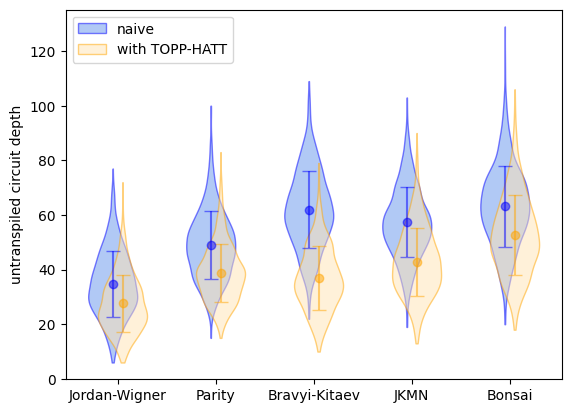

In [15]:
# plot results and print reduction statistics

order = ["JW", "parity", "BK", "JKMN", "bonsai"]
names = ["Jordan-Wigner", "Parity", "Bravyi-Kitaev", "JKMN", "Bonsai"]

spacing = 0.05

naive_data = [untranspiled_results[name]["naive"] for name in order]
tophatt_data = [untranspiled_results[name]["topphatt"] for name in order]

positions_naive = [i + 1 - spacing for i in range(len(order))]
positions_tophatt = [i + 1 + spacing for i in range(len(order))]

plt.tight_layout()

naive_violin = plt.violinplot(
    dataset=naive_data,
    positions=positions_naive,
)
tophatt_violin = plt.violinplot(
    dataset=tophatt_data,
    positions=positions_tophatt,
)

alpha = 0.5
naive_edge = "blue"
naive_fill = "cornflowerblue"
tophatt_edge = "orange"
tophatt_fill = "moccasin"

for i, body in enumerate(naive_violin["bodies"]):
    body.set_facecolor(naive_fill)
    body.set_edgecolor(naive_edge)
    body.set_alpha(alpha)

naive_violin["bodies"][0].set_label("naive")

for i, body in enumerate(tophatt_violin["bodies"]):
    body.set_facecolor(tophatt_fill)
    body.set_edgecolor(tophatt_edge)
    body.set_alpha(alpha)

tophatt_violin["bodies"][0].set_label("with TOPP-HATT")


for key in ["cbars", "cmaxes", "cmins"]:
    naive_violin[key].set_color("none")
    tophatt_violin[key].set_color("none")

reductions = []

for i, encoding in enumerate(order):
    x_naive = positions_naive[i]
    x_topphatt = positions_tophatt[i]

    y_naive = np.mean(untranspiled_results[encoding]["naive"])
    e_naive = np.std(untranspiled_results[encoding]["naive"])

    y_topphatt = np.mean(untranspiled_results[encoding]["topphatt"])
    e_topphatt = np.std(untranspiled_results[encoding]["topphatt"])

    plt.errorbar(
        x=x_naive,
        y=y_naive,
        yerr=e_naive,
        fmt="o",
        color=naive_edge,
        capsize=5,
        alpha=alpha,
    )

    plt.errorbar(
        x=x_topphatt,
        y=y_topphatt,
        yerr=e_topphatt,
        fmt="o",
        color=tophatt_edge,
        capsize=5,
        alpha=alpha,
    )

    reduction = 100 * (1 - y_topphatt / y_naive)
    reductions.append(reduction)

    print(encoding)
    print("naive", len(untranspiled_results[encoding]["naive"]))
    print(f"{y_naive:.1f}", f"{e_naive:.1f}")
    print("TOPP-HATT", len(untranspiled_results[encoding]["topphatt"]))
    print(f"{y_topphatt:.1f}", f"{e_topphatt:.1f}")
    print("reduction")
    print(reduction)
    print()

print()
print("mean reduction over all encodings:")
print(f"{np.mean(reductions):.1f}, {np.std(reductions):.1f}")

plt.legend(loc="upper left")
plt.xticks([i + 1 for i in range(len(order))], names)
plt.ylabel("untranspiled circuit depth")

# plt.savefig("untranspiled_qdrift.pdf")

plt.show()

In [16]:
# save one circuit with mean depth for each encoding and variant in results dictionary

for encoding in untranspiled_results.keys():
    data = untranspiled_results[encoding]
    hams = data["hams"]

    for variant, ham in zip(["naive", "topphatt"], hams):
        target_depth = int(np.mean(data[variant]))

        trial = 0

        while True:
            seed = ROOT_SEED + trial
            qdrift = qdrift = QDriftSimulation(
                ham=ham, duration=dur, error=1e-3, seed=seed
            )
            trial += 1

            if qdrift.depth() == target_depth:
                untranspiled_results[encoding][f"{variant}_mean_depth"] = target_depth
                untranspiled_results[encoding][f"{variant}_mean_qasm"] = (
                    qiskit.qasm2.dumps(qdrift)
                )
                print(f"done {encoding} {variant} {target_depth}")
                break

done bonsai naive 63
done bonsai topphatt 52
done JW naive 34
done JW topphatt 27
done BK naive 61
done BK topphatt 36
done parity naive 48
done parity topphatt 38
done JKMN naive 57
done JKMN topphatt 42


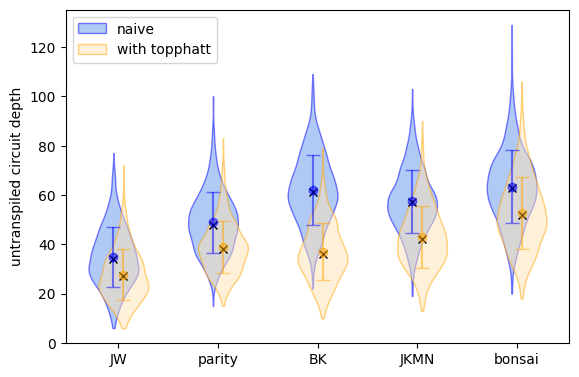

In [17]:
# sainty check to ensure mean depth circuits are correct

spacing = 0.05

naive_data = [untranspiled_results[name]["naive"] for name in order]
tophatt_data = [untranspiled_results[name]["topphatt"] for name in order]

positions_naive = [i + 1 - spacing for i in range(len(order))]
positions_tophatt = [i + 1 + spacing for i in range(len(order))]

plt.figure(figsize=(468 / 72, (468 * (2 / 3)) / 72))
plt.tight_layout()

naive_violin = plt.violinplot(
    dataset=naive_data,
    positions=positions_naive,
)
tophatt_violin = plt.violinplot(
    dataset=tophatt_data,
    positions=positions_tophatt,
)

alpha = 0.5
naive_edge = "blue"
naive_fill = "cornflowerblue"
tophatt_edge = "orange"
tophatt_fill = "moccasin"

for i, body in enumerate(naive_violin["bodies"]):
    body.set_facecolor(naive_fill)
    body.set_edgecolor(naive_edge)
    body.set_alpha(alpha)

naive_violin["bodies"][0].set_label("naive")

for i, body in enumerate(tophatt_violin["bodies"]):
    body.set_facecolor(tophatt_fill)
    body.set_edgecolor(tophatt_edge)
    body.set_alpha(alpha)

tophatt_violin["bodies"][0].set_label("with topphatt")


for key in ["cbars", "cmaxes", "cmins"]:
    naive_violin[key].set_color("none")
    tophatt_violin[key].set_color("none")

for i, name in enumerate(order):
    x_naive = positions_naive[i]
    x_topphatt = positions_tophatt[i]

    y_naive = np.mean(untranspiled_results[name]["naive"])
    e_naive = np.std(untranspiled_results[name]["naive"])

    y_topphatt = np.mean(untranspiled_results[name]["topphatt"])
    e_topphatt = np.std(untranspiled_results[name]["topphatt"])

    depth_naive = untranspiled_results[name]["naive_mean_depth"]
    depth_topphatt = untranspiled_results[name]["topphatt_mean_depth"]

    plt.errorbar(
        x=x_naive,
        y=y_naive,
        yerr=e_naive,
        fmt="o",
        color=naive_edge,
        capsize=5,
        alpha=alpha,
    )

    plt.errorbar(
        x=x_topphatt,
        y=y_topphatt,
        yerr=e_topphatt,
        fmt="o",
        color=tophatt_edge,
        capsize=5,
        alpha=alpha,
    )

    plt.plot(x_naive, depth_naive, "x", color="black")
    plt.plot(x_topphatt, depth_topphatt, "x", color="black")

plt.legend(loc="upper left")
plt.xticks([i + 1 for i in range(len(order))], order)
plt.ylabel("untranspiled circuit depth")

plt.show()

## now we will transpile these circuits

We can load in a QPU backend for transpilation with the Qiskit transpiler. We will use the IQM Garnet 20-qubit device. 

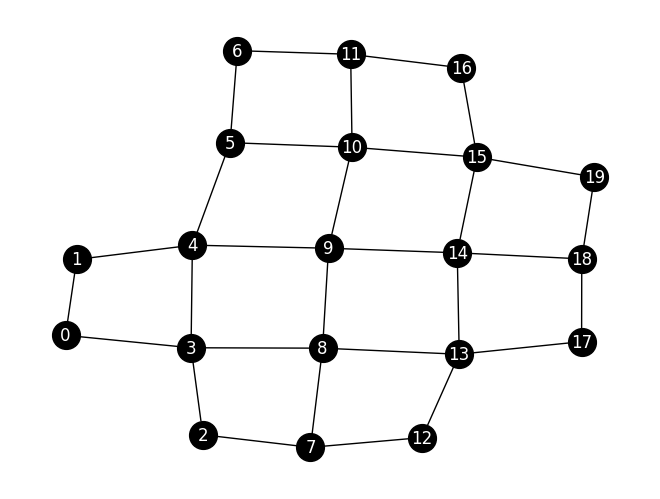

In [18]:
rx.visualization.mpl_draw(
    graph=garnet_graph_rx,
    with_labels=True,
    node_color="black",
    node_size=400,
    font_color="white",
    pos=rx.spring_layout(garnet_graph_rx, seed=5),
)

In [19]:
coupling_map = CouplingMap(iqm_garnet_config["coupling_map"])
basis_gates = iqm_garnet_config["basis_gates"]

In [20]:
# transpilation function based on IQM Garnet topology


def transpile_for_iqm(
    circuit,
    coupling_map,
    basis_gates,
    optim_level,
    root_seed=None,
    trial=None,
):
    seed = None if root_seed is None else root_seed + trial
    return transpile(
        circuit,
        basis_gates=basis_gates,
        coupling_map=coupling_map,
        optimization_level=optim_level,
        seed_transpiler=seed,
    )

In [21]:
# results dictionary

transpiled_results = {
    "bonsai": {"naive": [], "topphatt": []},
    "JW": {"naive": [], "topphatt": []},
    "BK": {"naive": [], "topphatt": []},
    "parity": {"naive": [], "topphatt": []},
    "JKMN": {"naive": [], "topphatt": []},
}

In [22]:
# now transpile the mean depth circuits 1000 times (takes approx 2 minutes)

optim_level = 3
repeats = 1000

for encoding in untranspiled_results.keys():
    for variant in ["naive", "topphatt"]:
        qasm_string = untranspiled_results[encoding][f"{variant}_mean_qasm"]
        qc = qiskit.qasm2.loads(qasm_string)
        for i in range(repeats):
            qc_transpiled = transpile_for_iqm(
                circuit=qc,
                coupling_map=coupling_map,
                basis_gates=basis_gates,
                optim_level=optim_level,
                root_seed=ROOT_SEED,
                trial=i,
            )
            transpiled_results[encoding][variant].append(qc_transpiled.depth())

JW
naive 1000
84.3 3.8
TOPP-HATT 1000
68.3 7.9
reduction
19.00934224877887

parity
naive 1000
151.2 11.6
TOPP-HATT 1000
100.5 8.1
reduction
33.520487791974176

BK
naive 1000
200.5 9.7
TOPP-HATT 1000
126.9 10.0
reduction
36.71528914075907

JKMN
naive 1000
236.5 20.8
TOPP-HATT 1000
172.7 17.5
reduction
26.976462977917382

bonsai
naive 1000
181.8 13.9
TOPP-HATT 1000
152.2 7.1
reduction
16.312298571161442


mean reduction over all encodings:
26.5, 7.9


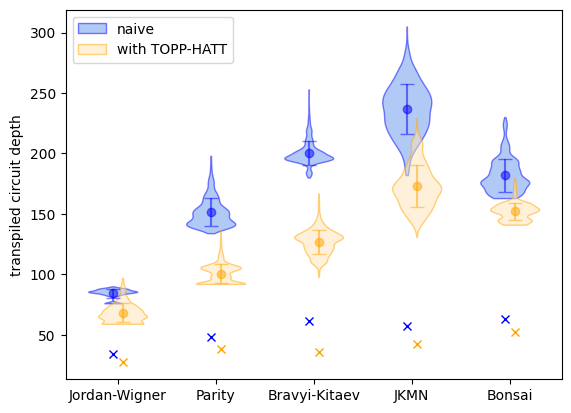

In [23]:
# plot transpiled results and print reduction statistics

order = ["JW", "parity", "BK", "JKMN", "bonsai"]
names = ["Jordan-Wigner", "Parity", "Bravyi-Kitaev", "JKMN", "Bonsai"]

spacing = 0.05

naive_data = [transpiled_results[name]["naive"] for name in order]
tophatt_data = [transpiled_results[name]["topphatt"] for name in order]

positions_naive = [i + 1 - spacing for i in range(len(order))]
positions_tophatt = [i + 1 + spacing for i in range(len(order))]

plt.tight_layout()

naive_violin = plt.violinplot(
    dataset=naive_data,
    positions=positions_naive,
)
tophatt_violin = plt.violinplot(
    dataset=tophatt_data,
    positions=positions_tophatt,
)

alpha = 0.5
naive_edge = "blue"
naive_fill = "cornflowerblue"
tophatt_edge = "orange"
tophatt_fill = "moccasin"

for i, body in enumerate(naive_violin["bodies"]):
    body.set_facecolor(naive_fill)
    body.set_edgecolor(naive_edge)
    body.set_alpha(alpha)

naive_violin["bodies"][0].set_label("naive")

for i, body in enumerate(tophatt_violin["bodies"]):
    body.set_facecolor(tophatt_fill)
    body.set_edgecolor(tophatt_edge)
    body.set_alpha(alpha)

tophatt_violin["bodies"][0].set_label("with TOPP-HATT")

for key in ["cbars", "cmaxes", "cmins"]:
    naive_violin[key].set_color("none")
    tophatt_violin[key].set_color("none")

reductions = []

for i, encoding in enumerate(order):
    x_naive = positions_naive[i]
    x_topphatt = positions_tophatt[i]

    y_naive = np.mean(transpiled_results[encoding]["naive"])
    e_naive = np.std(transpiled_results[encoding]["naive"])

    y_topphatt = np.mean(transpiled_results[encoding]["topphatt"])
    e_topphatt = np.std(transpiled_results[encoding]["topphatt"])

    plt.errorbar(
        x=x_naive,
        y=y_naive,
        yerr=e_naive,
        fmt="o",
        color=naive_edge,
        capsize=5,
        alpha=alpha,
    )

    plt.errorbar(
        x=x_topphatt,
        y=y_topphatt,
        yerr=e_topphatt,
        fmt="o",
        color=tophatt_edge,
        capsize=5,
        alpha=alpha,
    )

    naive_depth = untranspiled_results[encoding]["naive_mean_depth"]
    tophatt_depth = untranspiled_results[encoding]["topphatt_mean_depth"]

    plt.plot(x_naive, naive_depth, "x", color=naive_edge)
    plt.plot(x_topphatt, tophatt_depth, "x", color=tophatt_edge)

    reduction = 100 * (1 - y_topphatt / y_naive)
    reductions.append(reduction)

    print(encoding)
    print("naive", len(transpiled_results[encoding]["naive"]))
    print(f"{y_naive:.1f}", f"{e_naive:.1f}")
    print("TOPP-HATT", len(transpiled_results[encoding]["topphatt"]))
    print(f"{y_topphatt:.1f}", f"{e_topphatt:.1f}")
    print("reduction")
    print(reduction)
    print()

print()
print("mean reduction over all encodings:")
print(f"{np.mean(reductions):.1f}, {np.std(reductions):.1f}")

plt.legend(loc="upper left")
plt.xticks([i + 1 for i in range(len(order))], names)
plt.ylabel("transpiled circuit depth")

# plt.savefig("transpiled_qdrift.pdf")

plt.show()

# water with different qDRIFT durations

We can also compare TOPP-HATT with naive methods by considering a batch of qDRIFT circuits with standard JW and optimised JW over a range of evolution durations.

In [60]:
durations = np.logspace(-3, -2, num=10, endpoint=True, base=10)
durations

array([0.001     , 0.00129155, 0.0016681 , 0.00215443, 0.00278256,
       0.00359381, 0.00464159, 0.00599484, 0.00774264, 0.01      ])

In [61]:
# results dictionary

duration_scan_results = {str(i): {"JW": [], "TH": []} for i, _ in enumerate(durations)}

In [62]:
# run 100 scans over the duration range (takes approx 7 minutes)

repeats = 100
for trial in range(repeats):
    for dur_idx, duration in enumerate(durations):
        naive_depth, tophatt_depth = run_qdrift(
            hams=jw_hams, duration=duration, root_seed=ROOT_SEED, trial=trial
        )

        duration_scan_results[str(dur_idx)]["JW"].append(naive_depth)
        duration_scan_results[str(dur_idx)]["TH"].append(tophatt_depth)

    print("done repeat", trial + 1, "of", repeats, end="\r")

In [63]:
# calculate means and standard deviations
JW_mean_depths = []
JW_std_depths = []
TH_mean_depths = []
TH_std_depths = []

for i, _ in enumerate(durations):
    JW_mean_depths.append(np.mean(duration_scan_results[str(i)]["JW"]))
    JW_std_depths.append(np.std(duration_scan_results[str(i)]["JW"]))
    TH_mean_depths.append(np.mean(duration_scan_results[str(i)]["TH"]))
    TH_std_depths.append(np.std(duration_scan_results[str(i)]["TH"]))

JW_mean_depths = np.array(JW_mean_depths)
JW_std_depths = np.array(JW_std_depths)
TH_mean_depths = np.array(TH_mean_depths)
TH_std_depths = np.array(TH_std_depths)

In [71]:
# print all results

reductions = []

for i, depth in enumerate(JW_mean_depths):
    reductions.append(100 * (1 - TH_mean_depths[i] / depth))
    print(
        f"{durations[i]:.4f}",
        "&",
        f"{depth:.1f}",
        "&",
        f"{TH_mean_depths[i]:.1f}",
        "&",
        f"{100 * (1 - TH_mean_depths[i] / depth):.1f}",
        r" \\"
    )

print()
print("mean reduction over all durations:")
print(f"{np.mean(reductions):.1f}, {np.std(reductions):.1f}")

0.0010 & 34.1 & 27.9 & 18.1  \\
0.0013 & 53.3 & 42.3 & 20.6  \\
0.0017 & 86.2 & 68.3 & 20.8  \\
0.0022 & 140.5 & 112.2 & 20.2  \\
0.0028 & 227.9 & 182.8 & 19.8  \\
0.0036 & 380.1 & 305.7 & 19.6  \\
0.0046 & 631.6 & 507.4 & 19.7  \\
0.0060 & 1042.2 & 842.2 & 19.2  \\
0.0077 & 1751.4 & 1409.6 & 19.5  \\
0.0100 & 2930.8 & 2352.6 & 19.7  \\

mean reduction over all durations:
19.7, 0.7


In [110]:
# fit polynomials to the mean depth data
from scipy.optimize import curve_fit

def func(x,a): return a*(x**2)

JW_fit = curve_fit(func, durations, JW_mean_depths)
TH_fit = curve_fit(func, durations, TH_mean_depths)
print("Naive Jordan-Wigner")
print(JW_fit)
print()
print("TOPP-HATT Jordan-Wigner")
print(TH_fit)

Naive Jordan-Wigner
(array([29265850.88068224]), array([[1.52406737e+09]]))

TOPP-HATT Jordan-Wigner
(array([23520271.83134056]), array([[4.31875683e+08]]))


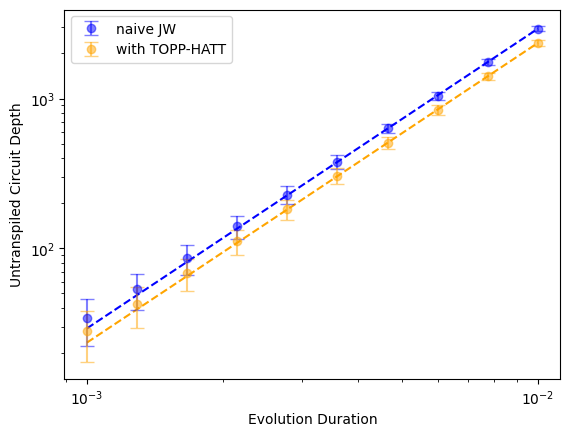

In [100]:
# plot results

naive_edge = "blue"
naive_fill = "cornflowerblue"
tophatt_edge = "orange"
tophatt_fill = "moccasin"

plt.tight_layout()

durations_fine = np.linspace(min(durations), max(durations), 100)

plt.plot(durations_fine, func(durations_fine, *JW_fit[0]), "--", color=naive_edge)
plt.plot(durations_fine, func(durations_fine, *TH_fit[0]), "--", color=tophatt_edge)

plt.errorbar(
    durations,
    JW_mean_depths,
    yerr=JW_std_depths,
    fmt="o",
    color=naive_edge,
    capsize=5,
    alpha=0.5,
    label="naive JW",
)

plt.errorbar(
    durations,
    TH_mean_depths,
    yerr=TH_std_depths,
    fmt="o",
    color=tophatt_edge,
    capsize=5,
    alpha=0.5,
    label="with TOPP-HATT",
)

plt.xlabel("Evolution Duration")
plt.ylabel("Untranspiled Circuit Depth")

plt.yscale("log")
plt.xscale("log")

plt.legend()

# plt.savefig("qdrift_durations_scan.pdf")

plt.show()

In [103]:
TH_fit[0]/JW_fit[0]

array([0.80367634])

In [109]:
print(f"{TH_fit[0][0]:.4e}, {JW_fit[0][0]:.4e}")

2.3520e+07, 2.9266e+07
